# Assignment #4 - Reinforcement Learning

### <font color="red"> DUE: Nov 26 (Tuesday) 11:00 pm </font>  

<font color="blue"> <b>Kruti Raval</b> </font>

# I. Overview

The main objective of this assignment is to understand the use of Q-learning and SARSA algorithms to play a simple card game of Rummy. The core idea of using these algorithms is to repeatedly update the Q-values of the environment until the agent can optimally navigate to the goal node or win consistently in a game of Rummy. While implementing this, I also learnt how changing different parameters affects the agents learning.

# II. Problems 



## Rummy (Our Way)
![](https://upload.wikimedia.org/wikipedia/commons/9/9a/3_playing_cards.jpg)



### Description:
Rummy is mostly played by 4 players where each player get 10 cards and rest of placed as closed deck.  

But for this assignment to keep it simple, we have changed some rules, reduced the deck of cards and distribution of the cards among each player. Otherwise, the our Q table would be large to handle on our local machines.  

So in this game each player will get 3 cards randomly from 'A' to '5'. With each turn you have to pick a card either from the pile of closed or open cards depending on the cards you have. After that you have to select a card to drop to the pile from your deck. Your goal is to make all of your 3 cards of same number. As soon as one player reaches the goal state, it will meld the cards and game will stop and all other player will get score as the sum of their cards in hand. Player with minimum score will win the game.  

Each player will play for the 10 rounds and if nobody reach to the meld stage then each will player will get score equivalent to the sum of their cards in hand.

Player with the lowest score wins the game.



### <font color="red"> Game Introduction and Rules: </font>

You can only till max turns which is now 20. If you are able to meld your cards, you win otherwise you lose points as per your stash score.

Lets Simulate a Game Round :
The Goal of this game is to collect cards with the same rank.
Naming Conventions to follow H : Hearts, S : Spades, D : Diamonds, C : Clubs. Stash/Hand are the cards which you have. Stash/Hand Score: The sum of the rank of cards. 

- On the first turn you will be given 3 cards from the randomly shuffled deck. Eg: 3H, 2S, AD. Stash Score: 6
- In the next step you will have to either pick a card from pile or the deck. On the first turn, the top card of the deck is on the pile. The card on the pile is visible to you. So Card on the Pile : 2D . You have to decide whether you have to pick this card or you have to pick from pile. Since you alread
- Following the pickup step, you will have to drop one card from the stash/hand. Your Hand : 3H, 2S, AD, 2D
- You can drop any of these cards, but remember if you drop 2S or 2D you might not be able to make a series. So you have to decide whether to drop 3H or AD. Since there are maximum 20 turns, you have to keep your score low as well, Higher the score the higher points you lose. So you decide to drop 3H. Your hand/stash will be: 2S, 2D, AD
- Your opponent will play his hand, he/she shall pick up a card from a pile or deck and the drop a card to the pile.
- Now its your turn. The card on the Pile : 5H. Since picking up this card won't help you much. You decide to pick a card from the Deck. You get lucky, you get a 2C card. Your hand now is 2S, 2D, 2C, AD. Hurray! You can now meld these cards and drop the last card to make your score 0.
- You win this round. Your opponent Stash/Hand score : 15. So you are at 0 points and your opponent is at 15 points. You are ahead of him since you have to keep your score as low as possible.


## Rummy Environment

Importing Libraries

In [44]:
import random 
from functools import reduce
from collections import defaultdict
import numpy as np
from copy import copy
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

Here, we define the SUITS, RANKS of the cards and their RANK_VALUE.

In [45]:
SUIT = ['H','S','D','C']
RANK = ['A', '2', '3', '4', '5','6','7']
RANK_VALUE = {'A': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'T': 10, 'Q': 10, 'K': 10}

## Card Class Definition
__init__  : Defines the card details such as rank, suit and calculates the rank value


In [46]:
class Card :
    def __init__(self,rank,suit):
        self.rank = rank
        self.suit = suit
        self.rank_to_val = RANK_VALUE[self.rank]
    
    def __str__(self):
        return f'{self.rank}{self.suit}'

    def __repr__(self):
        return f'{self.rank}{self.suit}'

    
    def __eq__(self,other):
        return self.rank == other.rank and self.suit == other.suit
  
# Deck class contains some basic operations performed with the cards:
# 1. Shuffling the cards.
# 2. Drawing card from the deck.

## Deck Class Definition
__shuffle__ : Shuffles the deck in random order

__draw_card__ : Draws a card from the top of the deck

In [47]:
class Deck:
    def __init__(self,packs):
        self.packs = packs
        self.cards = []
        for pack in range(0,packs) :
            for suit in SUIT :
                for rank in RANK :
                    self.cards.append(Card(rank,suit))
    
    def shuffle(self):
        random.shuffle(self.cards)
    
    def draw_card(self):
        card = self.cards[0]
        self.cards.pop(0)
        return card

## Player Class:

### 1.__init__(self,name,stash=list(),isBot=False): 
Initializing stash, name, isBot/dealer points for each player.

### 2. deal_card(self,card):
This method appends the card in the stash and check the condition that length of stash should not be greater than nuber of cards length in game.

### 3. drop_card(self,card):
This method removes the card from stash and add that card into pile.

### 4. meld(self):
This method tries to find the cards with the same rank in the hand. If it finds then it will merge the cards in the hand to the melded cards array in the game. 

### 5. stash_score(self):
This method calculates sum of all the cards in stash according to the rank of each card.

### 6. get_info(self,debug):
This function fetch all the information of the player.

In [48]:
class Player:
  
    """  
        Player class to create a player object.
        eg: player = Player("player1", list(), isBot = False)
        Above declaration will be for your agent.
        All the player names should be unique or else you will get error.
        
    """

    def __init__(self,name,stash=list(),isBot=False,points=0,conn=None):
        self.stash = stash
        self.name = name
        self.game = None
        self.isBot = isBot
        self.points = points
        self.conn = conn
        
    def deal_card(self,card):
        try :
            self.stash.append(card)
            if len(stash) > self.game.cardsLength + 1 :
                raise ValueError('Cannot have cards greater than ')
        except ValueError as err:
            print(err.args)
            
    def drop_card(self,card):
        self.stash.remove(card)
        self.game.add_pile(card)
        return -1

    
    def meld(self):
        card_hash = defaultdict(list)
        for card in self.stash:
            card_hash[card.rank].append(card)
        melded_card_ranks = []
        for (card_rank,meld_cards) in card_hash.items():
            if len(meld_cards) >= 3 :
                self.game.meld.append(meld_cards)
                melded_card_ranks.append(card_rank)
                for card in meld_cards:
                    self.stash.remove(card)
        
        for card_rank in melded_card_ranks :
            card_hash.pop(card_rank)
        return len(melded_card_ranks) > 0

    def stash_score(self) :
        score = 0
        for card in self.stash :
            score += RANK_VALUE[card.rank]
        return score
    
    def get_info(self,debug):
        if debug :
            print(f'Player Name : {self.name} \n Stash Score: {self.stash_score()} \n Stash : {", ".join(str(x) for x in self.stash)}')
        card_ranks = []
        card_suits = []
        pileset = None
        pile = None
        for card in self.stash :
            card_suits.append(RANK_VALUE[card.rank])
            card_ranks.append(card.suit)
        if len(self.game.pile) > 0 : 
            return {"Stash Score" : self.stash_score(), "CardSuit":  card_suits, "CardRanks": card_ranks, "PileRank": self.game.pile[-1].rank, "PileSuit":self.game.pile[-1].suit}
        return {"Stash Score" : self.stash_score(), "CardSuit":  card_suits, "CardRanks": card_ranks}


## Game Enviroment:

### 1. __init():  

### 2. add_pile(self, card):  This method takes a card as argument and first checks number of cards in the deck. If its is ‘0’ then add the cards from file to deck and append the passed card to the pile.

### 3. pick_card(self, player, action):  This methods helps player picking up the card from either Pile or Deck based on action.
			We have defined, If action = 0 then, player will pick a card from Pile
			And if action. = 1 then player will pick card from Deck. 
			Meld condition will be check after player picks the card, if the meld condition satisfied, player won. 
            You can modify the rewards in return, only the values

### 4. pick_from_pile(self, player): This method helps player picking card from the pile and simultaneously a card from pile gets reduced.

### 5. pick_from_deck(self, player): This method is similar to above method but it helps picking up card from the Deck. 

### 6. get_player(self, player_name): This function fetch the details of the player given player_name.

### 7. computer_play(self, player): This method defines the play of the computer/Dealer in following sequence:
			--> Randomly taking actions from picking up card from deck/pile.
			--> Checking the meld condition afterwards.
			--> If the meld condition does not satisfied, remove the card from his stash.

### 8. play(self): This method defines all the function city of play for the player:
		  --> Decrementing the maximum number of turns defined per game.
		  --> For each player, it will check the 'stash', if the 'Stash' for any player = 0 (That player won), it will add the value of each card in stash for all other players.
		  --> Or If maximum number of turns in each round becomes 0, it will add the card values in stash for all the players and return.
      
### 9. drop_card(self,player,card) This method drops a card from the player given player object and card object and returns the reward associated with it.

      --> You can modify the rewards which gets returned in the value.


### 9. reset(self, players): This method will reinitialize all the deck, pile and players.

### 10. _update_turn(self): This method is used to count the number of turns in the game.

In [49]:
class RummyAgent() :
    """
    Simple Rummy Environment
    
    Simple Rummy is a game where you need to make all the cards in your hand same before your opponent does.
    Here you are given 3 cards in your hand/stash to play.
    For the first move you have to pick a card from the deck or from the pile. 
    The card in deck would be random but you can see the card from the pile.
    In the next move you will have to drop a card from your hand.
    Your goal is to collect all the cards of the same rank. 
    Higher the rank of the card, the higher points you lose in the game. 
    You need to keep the stash score low. Eg, if you can AH,7S,5D your strategy would be to either find the first pair of the card or by removing the highest card in the deck.
    You only have 20 turns to either win the same or collect low scoring card.
    You can't see other players cards or their stash scores.
    
    Parameters
    ====
    players: Player objects which will play the game.
    max_card_length : Number of cards each player can have
    max_turns: Number of turns in a rummy game
    """

    def __init__(self,players,max_card_length=5,max_turns=20) :
        self.max_card_length = max_card_length
        self.max_turns = max_turns
        self.reset(players)
        
    def update_player_cards(self,players):
        for player in players :
            player = Player(player.name,list(),isBot=player.isBot,points=player.points,conn=player.conn)
            stash = []
            for i in range(self.max_card_length):
                player.stash.append(self.deck.draw_card())
            player.game = self
            self.players.append(player)
        self.pile = [self.deck.draw_card()]

    def add_pile(self,card):
        if len(self.deck.cards) == 0 :
            self.deck.cards.extend(self.pile)
            self.deck.shuffle()
            self.pile = []
        self.pile.append(card)
        
        
    def pick_card(self,player,action):
        if action == 0:
            self.pick_from_pile(player)
        else :
            self.pick_from_deck(player)
        if player.meld() :
            return {"reward" : 10}
        else :
            return {"reward" : -1}
#             return -player.stash_score()
       
    def pick_from_pile(self,player):
        card = self.pile[-1]
        self.pile.pop()
        return player.stash.append(card)
     
    def pick_from_deck(self,player):
        return player.stash.append(self.deck.draw_card())
    
    def get_player(self,player_name):
        return_player = [player for player in self.players if player.name == player_name]
        if len(return_player) != 1:
            print("Invalid Player")
            return None
        else:
            return return_player[0]
    
    def drop_card(self,player,card):
        player.drop_card(card)
        return {"reward" : -1}
    
  
    def computer_play(self,player):
        #Gets a card from deck or pile
        if random.randint(0,1) == 1 :
            self.pick_from_pile(player)
        else :
            self.pick_from_deck(player)
            
        #tries to meld if it can
#         if random.randint(0,10) > 5 :
        player.meld()
        
        #removes a card from the stash
        if len(player.stash) != 0:
            card = player.stash[(random.randint(0,len(player.stash) - 1))]
            player.drop_card(card)
        
    def play(self):
        for player in self.players :
            if len(player.stash) == 0 :
                return True
        if self.max_turns <= 0 :
            return True
        return False

    def _update_turn(self):
        self.max_turns -= 1  
    
    def reset(self,players,max_turns=20):
        self.players = []
        self.deck = Deck(1)
        self.deck.shuffle()
        self.meld = []
        self.pile = []
        self.max_turns = max_turns
        self.update_player_cards(players)




### Example Run with Random Players

This following code shows how to create an environment and players to play 10 games with 20 maximum rounds. This only includes random picking up of card and dropping.  

In [50]:
p1 = Player('tabish',list())
p2 = Player('comp1',list(),isBot=True)
rummy = RummyAgent([p1,p2],max_card_length=3,max_turns=20)

In [51]:
maxiter = 3
debug = True
for j in range(maxiter):
        for player in rummy.players :
            player.points = player.stash_score()
        
        rummy.reset(rummy.players)
        random.shuffle(rummy.players)
        # int i = 0 
        if debug :
            print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
        while not rummy.play() :    
            rummy._update_turn()
            print(rummy.max_turns)       
            for player in rummy.players:
                if player.isBot :
                    if rummy.play():
                        continue
                    if debug :
                        print(f'{player.name} Plays')
                    rummy.computer_play(player)
                    if debug :
                        player.get_info(debug)
                        if player.stash == 0 :
                            print(f'{player.name} wins the round')

                else :
                    if rummy.play() :
                        continue
                    if debug :
                        print(f'{player.name} Plays')
                    player_info = player.get_info(debug)
                    action_taken = np.random.choice(1)
                    if debug :
                        print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                    result_1 = rummy.pick_card(player,action_taken)
                    result_1 = result_1["reward"]

                    if debug : 
                        print(f'{player.name} takes action {action_taken}')
                    #player stash will have no cards if the player has melded them 
                    #When you have picked up a card and you have drop it since the remaining cards have been melded. 
                    if len(player.stash) == 1:
                        rummy.drop_card(player,player.stash[0])
                        if debug :
                            print(f'{player.name} Wins the round')

                    elif len(player.stash) != 0 :

                        player_info = player.get_info(debug)
                        s = player_info['CardRanks']
                        action_taken = np.random.choice(4)
                        card = player.stash[action_taken]
                        if debug :
                            print(f'{player.name} drops card {card}')

                        result_1 = rummy.drop_card(player,card)
                        result_1 = result_1["reward"]
#                             pdb.set_trace()
                    else :
                        if debug :
                            print(f'{player.name} Wins the round')
                    if debug :
                        player.get_info(debug)
        


**********************************
		Game Starts : 0
***********************************
19
tabish Plays
Player Name : tabish 
 Stash Score: 9 
 Stash : 3H, 4H, 2D
Card in pile D6
tabish takes action 0
Player Name : tabish 
 Stash Score: 15 
 Stash : 3H, 4H, 2D, 6D
tabish drops card 4H
Player Name : tabish 
 Stash Score: 11 
 Stash : 3H, 2D, 6D
comp1 Plays
Player Name : comp1 
 Stash Score: 15 
 Stash : 5S, 6S, 4H
18
tabish Plays
Player Name : tabish 
 Stash Score: 11 
 Stash : 3H, 2D, 6D
Card in pile H2
tabish takes action 0
Player Name : tabish 
 Stash Score: 13 
 Stash : 3H, 2D, 6D, 2H
tabish drops card 2D
Player Name : tabish 
 Stash Score: 11 
 Stash : 3H, 6D, 2H
comp1 Plays
Player Name : comp1 
 Stash Score: 17 
 Stash : 6S, 4H, 7C
17
tabish Plays
Player Name : tabish 
 Stash Score: 11 
 Stash : 3H, 6D, 2H
Card in pile S5
tabish takes action 0
Player Name : tabish 
 Stash Score: 16 
 Stash : 3H, 6D, 2H, 5S
tabish drops card 2H
Player Name : tabish 
 Stash Score: 14 
 Stash : 3H, 

# III. Methods

- Decide your TD learning approach: SARSA or Q-learning? 
- Decide your function approximator.
- Describe your approach and the reason why you select it.
- Finish epsilon_greedy function and other TODOs. Explain it.
- Explain your codes.

## Review of SARSA and Q-learning

The two Temporal Difference learning approaches are
1. SARSA
2. Q-learning. 

By updating the Qtable, we can find the difference between them.
In SARSA we update the Q with assumption that we follow a certain behavior policy. Thus, we call this as on-policy control, or SARSA.
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t)) 
$$

In Q-learning without making assumption of behavior policy, we can explore other possible policies to update the Q. We call this as off-policy control, or Q-learning.
$$
    Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha ( R_{t+1} + \gamma \max_a Q(s_{t+1}, a) - Q(s_t, a_t)) 
$$


The major difference is that Q-learning uses the action with maximum reward to update the action value. In SARSA, we use an action that is taken in previous state.

If we observe above two formulas used for updating the Q table we can see that SARSA uses actual action that corresponds to s(t+1) to update action at s(t) where as in Q learning it using maximum reward action value at s(t+1) to update action at s(t).



## Choice of TD learning and Reason

Choosing Q learning approach over SARSA is better according to me because of agents performance during the process of learning. Exploring all the possible policies and learning optimal greedy policy. Agent should explore and learn the optimal policy of reaching the goal in minimum number of steps. In the case of Rummy game the agent must know to learn by exploring.

SARSA will approach convergence allowing for possible penalities from exploratory moves, while Q learning ignores them. SARSA is very conservative and if there is any large negative closer to optimal path it tends to avoid it where as Q learning tend to trigger that large negative reward in the name of exploration.

Optimal policies are learnt directly as there is no risk or damage occured to agents or environment performing actions while exploring. I previously mentioned I decided to go with Q-learning due to its off-policy learning. Q-learning tends to find the optimal policy and has a rather simple convergence, all that is required is that all state-action pairs are continuously updated. Q-learning seems to provide robustness and is thus better.

## Choice of Function Approximation and Reason

$$
a^* = \arg \max_a Q(S_t, a)
$$

This can cause limited experience to develop good Q estimation. 
Without new data, greedy action selection will repeat the same actions, or repeatedly exploit the current knowledge. Thus, you need to explore other non-greedy actions to increase the experience to improve the Q estimation. This is called "exploration-exploitation dilemma." 

One of the way for this dilemma is $\epsilon$-greedy action selection. With a parameter $\epsilon \in [0, 1]$, we can control the exploration and exploitation level. When $\epsilon = 0$, the actions are selected in greedy manner, but when $\epsilon = 1$, the actions are selected randomly. 

## Implementation of the selected approach (RLAgent)

In [52]:
class Rummy():
   
    def __init__(self, env):
        print(env.players[0].name)
        env.reset(env.players)
        random.shuffle(env.players)
        env._update_turn()
        self.p1 = env.get_player(env.players[0].name)
       
        #self.pck_card = env.pick_card(self.p1, 0)
        #self.drp_card = env.drop_card(self.p1, card)
        self.actions = [0,1]
        self.action_taken = len(self.actions)
        self.action_taken1 = len(self.actions)
        self.Q = np.zeros((8, 8, 3))
       
    def epsilon_greed(self, epsilon, s):
        if np.random.uniform() < epsilon:
            a = np.random.randint(self.action_taken)
        else:
            i_max = np.where(self.Q[s[0], s[1], :] == np.max(self.Q[s[0], s[1], :]))[0]
            a = int(np.random.choice(i_max))
        return a
       
    def train(self, env, **params):
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000)
        maxstep= params.pop('maxstep', 1000)
       
        s_rewards = []
        reward_result = []
        for player in env.players :
            player.points = player.stash_score()
       
        for j in range(maxiter):
            step = 0
            env.reset(env.players)
            random.shuffle(env.players)
            # int i = 0
            if debug :
                print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
            while not env.play() :    
                env._update_turn()
                print(env.max_turns)      
                for player in env.players:
                    if player.isBot :
                        if env.play():
                            continue
                        if debug :
                            print(f'{player.name} Plays')
                        env.computer_play(player)
                        if debug :
                            player.get_info(debug)
                            if player.stash == 0 :
                                print(f'{player.name} wins the round')
                        step = step+1
                    else :
                        s_rewards.append(np.sum(reward_result))
                       
                        if env.play() :
                            continue
                        if debug :
                            print(f'{player.name} Plays')
                        player_info = player.get_info(debug)                      
                        s = player_info['CardSuit'] #get current cards
                        action_taken = self.epsilon_greed(epsilon, s)
                        if debug :
                            print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                        result_1 = env.pick_card(player,action_taken)
                        r = result_1["reward"]
                        reward_result.append(r)
                        if debug :
                            print(f'{player.name} takes action {action_taken}')
                        #player stash will have no cards if the player has melded them
                        #When you have picked up a card and you have drop it since the remaining cards have been melded.
                        if len(player.stash) == 1:
                            env.drop_card(player,player.stash[0])
                            if debug :
                                print(f'{player.name} Wins the round')
                                return step, s_rewards, self.Q

                        elif len(player.stash) != 0 :

                            player_info = player.get_info(debug)
                            s1 = player_info['CardSuit']
                           
                            action_taken1 = self.epsilon_greed(epsilon, s1) 
                            print("State " , s1)

                            self.Q[s[0], s[1], action_taken] += alpha * (r + gamma * self.Q[s1[0], s1[1], action_taken1] -\
                                             self.Q[s[0], s[1], action_taken])
                            card = player.stash[action_taken]
                            if debug :
                                print(f'{player.name} drops card {card}')

                            result_1 = env.drop_card(player,card)
                            r = result_1["reward"]
                            reward_result.append(r)
                       
                        else :
                            if debug :
                                print(f'{player.name} Wins the round')
                        if debug :
                            player.get_info(debug)

## Explanation of the codes

The init function does the initialization of environment, size of the environment and Q-table with respect to size of the environment.

The greddy funcion returns the argument with maximum vlaue inside the array.

The epsilon_greedy function compares the value with epsilon and chooses what way to go according to the value of rewards.

The train function does the following:
- Initializes the parameters
- Initializes the Q value with all zeroes.
- Get the current state in variable 's' and current action in 'a'
- Get the reward for the next state
- Get the next step in variable 's1'
- Choose the next action 'a1' by epsilon_greed function
- Update Q-table with the given equation.
- Check if the goal state is reached, make update Q-table with 0 because when we reach goal state we want agent to stay in that state and not move any further
- Make next state current state.
- Make next action current acction.

$$
a^* = \arg \max_a Q(S_t, a)
$$

The function's sole purpose is to exploit the learned policy. It operates almost same function but without the Q-table updates and random actions. In order to exploit the current policy the function simply takes the maximal Q-value for every state-action pair.

## RLAgent for Rummy

Referencing the RLAgent in the lecture note, make your own agent class for the game. 

In [53]:
class Rummy():
   
    def __init__(self, env):
        print(env.players[0].name)
        env.reset(env.players)
        random.shuffle(env.players)
        env._update_turn()
        self.p1 = env.get_player(env.players[0].name)
       
        #self.pck_card = env.pick_card(self.p1, 0)
        #self.drp_card = env.drop_card(self.p1, card)
        self.actions = [0,1]
        self.action_taken = len(self.actions)
        self.action_taken1 = len(self.actions)
        self.Q = np.zeros((8, 8, 3))
       
    def epsilon_greed(self, epsilon, s):
        if np.random.uniform() < epsilon:
            a = np.random.randint(self.action_taken)
        else:
            i_max = np.where(self.Q[s[0], s[1], :] == np.max(self.Q[s[0], s[1], :]))[0]
            a = int(np.random.choice(i_max))
        return a
       
    def train(self, env, **params):
        gamma = params.pop('gamma', 0.99)
        alpha = params.pop('alpha', 0.1)
        epsilon= params.pop('epsilon', 0.1)
        maxiter= params.pop('maxiter', 1000)
        maxstep= params.pop('maxstep', 1000)
       
        s_rewards = []
        reward_result = []
        for player in env.players :
            player.points = player.stash_score()
       
        for j in range(maxiter):
            step = 0
            env.reset(env.players)
            random.shuffle(env.players)
            # int i = 0
            if debug :
                print(f'**********************************\n\t\tGame Starts : {j}\n***********************************')
            while not env.play() :    
                env._update_turn()
                print(env.max_turns)      
                for player in env.players:
                    if player.isBot :
                        if env.play():
                            continue
                        if debug :
                            print(f'{player.name} Plays')
                        env.computer_play(player)
                        if debug :
                            player.get_info(debug)
                            if player.stash == 0 :
                                print(f'{player.name} wins the round')
                        step = step+1
                    else :
                        s_rewards.append(np.sum(reward_result))
                       
                        if env.play() :
                            continue
                        if debug :
                            print(f'{player.name} Plays')
                        player_info = player.get_info(debug)                      
                        s = player_info['CardSuit'] #get current cards
                        action_taken = self.epsilon_greed(epsilon, s)
                        if debug :
                            print(f'Card in pile {player_info["PileSuit"]}{player_info["PileRank"]}')
                        result_1 = env.pick_card(player,action_taken)
                        r = result_1["reward"]
                        reward_result.append(r)
                        if debug :
                            print(f'{player.name} takes action {action_taken}')
                        #player stash will have no cards if the player has melded them
                        #When you have picked up a card and you have drop it since the remaining cards have been melded.
                        if len(player.stash) == 1:
                            env.drop_card(player,player.stash[0])
                            if debug :
                                print(f'{player.name} Wins the round')
                                return step, s_rewards, self.Q

                        elif len(player.stash) != 0 :

                            player_info = player.get_info(debug)
                            s1 = player_info['CardSuit']
                           
                            action_taken1 = self.epsilon_greed(epsilon, s1) 
                            print("State " , s1)

                            self.Q[s[0], s[1], action_taken] += alpha * (r + gamma * self.Q[s1[0], s1[1], action_taken1] -\
                                             self.Q[s[0], s[1], action_taken])
                            card = player.stash[action_taken]
                            if debug :
                                print(f'{player.name} drops card {card}')

                            result_1 = env.drop_card(player,card)
                            r = result_1["reward"]
                            reward_result.append(r)
                       
                        else :
                            if debug :
                                print(f'{player.name} Wins the round')
                        if debug :
                            player.get_info(debug)

In [54]:
p1 = Player('Kruti',list())
p2 = Player('comp',list(),isBot=True)
rummy_env = RummyAgent([p1],max_card_length=3,max_turns=20)
rummy = Rummy(rummy_env)

Kruti


In [55]:
step,rewards, qvalue = rummy.train(rummy_env, gamma=0.99,
       alpha=0.1,
       epsilon=0.1,
       maxiter=100,
       maxstep=2000)

**********************************
		Game Starts : 0
***********************************
19
Kruti Plays
Player Name : Kruti 
 Stash Score: 13 
 Stash : 7D, 5D, AH
Card in pile C3
Kruti takes action 2
Player Name : Kruti 
 Stash Score: 14 
 Stash : 7D, 5D, AH, AD
State  [7, 5, 1, 1]
Kruti drops card AH
Player Name : Kruti 
 Stash Score: 13 
 Stash : 7D, 5D, AD
18
Kruti Plays
Player Name : Kruti 
 Stash Score: 13 
 Stash : 7D, 5D, AD
Card in pile HA
Kruti takes action 0
Player Name : Kruti 
 Stash Score: 14 
 Stash : 7D, 5D, AD, AH
State  [7, 5, 1, 1]
Kruti drops card 7D
Player Name : Kruti 
 Stash Score: 7 
 Stash : 5D, AD, AH
17
Kruti Plays
Player Name : Kruti 
 Stash Score: 7 
 Stash : 5D, AD, AH
Card in pile D7
Kruti takes action 0
Player Name : Kruti 
 Stash Score: 14 
 Stash : 5D, AD, AH, 7D
State  [5, 1, 1, 7]
Kruti drops card 5D
Player Name : Kruti 
 Stash Score: 9 
 Stash : AD, AH, 7D
16
Kruti Plays
Player Name : Kruti 
 Stash Score: 9 
 Stash : AD, AH, 7D
Card in pile D5
Kruti 

In [56]:
pick = open("dict.pickle","wb")
pickle.dump(qvalue, pick)
pick.close()


# IV - Results

- Describe the choice of your parameters for $\gamma$, $\alpha$, and $\epsilon$. 
  - Run experiments to find good parameters
  - Show the experimental outputs to show the process of your selection
- Visualize the results and explain outputs (even from mine.)
  - Run the codes and tell me what you observe
  - Add more visualizations to enrich your explanation.

## Output plots and Experimental outputs that show the choice of parameters. 

In [57]:
num_gamma_values = [0.1,0.2,0.3,0.4,0.5]
avg_payout_vs_gamma=[]
for g in num_gamma_values:
    step,rewards, qvalue = rummy.train(rummy_env, 
                                   gamma=g, 
                                   alpha=0.1, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)
    avg_payout_vs_gamma.append(sum(rewards)/len(rewards))

**********************************
		Game Starts : 0
***********************************
19
Kruti Plays
Player Name : Kruti 
 Stash Score: 15 
 Stash : 4C, 4H, 7H
Card in pile D2
Kruti takes action 1
Player Name : Kruti 
 Stash Score: 21 
 Stash : 4C, 4H, 7H, 6D
State  [4, 4, 7, 6]
Kruti drops card 4H
Player Name : Kruti 
 Stash Score: 17 
 Stash : 4C, 7H, 6D
18
Kruti Plays
Player Name : Kruti 
 Stash Score: 17 
 Stash : 4C, 7H, 6D
Card in pile H4
Kruti takes action 2
Player Name : Kruti 
 Stash Score: 20 
 Stash : 4C, 7H, 6D, 3D
State  [4, 7, 6, 3]
Kruti drops card 6D
Player Name : Kruti 
 Stash Score: 14 
 Stash : 4C, 7H, 3D
17
Kruti Plays
Player Name : Kruti 
 Stash Score: 14 
 Stash : 4C, 7H, 3D
Card in pile D6
Kruti takes action 1
Player Name : Kruti 
 Stash Score: 17 
 Stash : 4C, 7H, 3D, 3H
State  [4, 7, 3, 3]
Kruti drops card 7H
Player Name : Kruti 
 Stash Score: 10 
 Stash : 4C, 3D, 3H
16
Kruti Plays
Player Name : Kruti 
 Stash Score: 10 
 Stash : 4C, 3D, 3H
Card in pile H7
Kr

Kruti Plays
Player Name : Kruti 
 Stash Score: 12 
 Stash : 3H, 3S, 6H
Card in pile SA
Kruti takes action 2
Player Name : Kruti 
 Stash Score: 16 
 Stash : 3H, 3S, 6H, 4H
State  [3, 3, 6, 4]
Kruti drops card 6H
Player Name : Kruti 
 Stash Score: 10 
 Stash : 3H, 3S, 4H
10
Kruti Plays
Player Name : Kruti 
 Stash Score: 10 
 Stash : 3H, 3S, 4H
Card in pile H6
Kruti takes action 0
Player Name : Kruti 
 Stash Score: 16 
 Stash : 3H, 3S, 4H, 6H
State  [3, 3, 4, 6]
Kruti drops card 3H
Player Name : Kruti 
 Stash Score: 13 
 Stash : 3S, 4H, 6H
9
Kruti Plays
Player Name : Kruti 
 Stash Score: 13 
 Stash : 3S, 4H, 6H
Card in pile H3
Kruti takes action 2
Player Name : Kruti 
 Stash Score: 14 
 Stash : 3S, 4H, 6H, AD
State  [3, 4, 6, 1]
Kruti drops card 6H
Player Name : Kruti 
 Stash Score: 8 
 Stash : 3S, 4H, AD
8
Kruti Plays
Player Name : Kruti 
 Stash Score: 8 
 Stash : 3S, 4H, AD
Card in pile H6
Kruti takes action 1
Player Name : Kruti 
 Stash Score: 14 
 Stash : 3S, 4H, AD, 6C
State  [3, 4, 

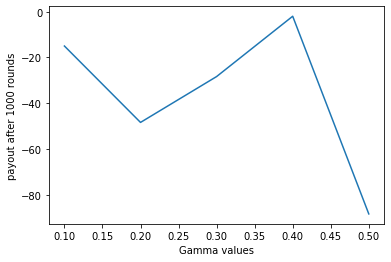

In [58]:
plt.plot(num_gamma_values, avg_payout_vs_gamma)
plt.xlabel('Gamma values')
plt.ylabel('payout after 1000 rounds')
plt.show()

In [59]:
num_alpha_values = [0.1,0.2,0.3,0.4,0.5]
avg_payout_vs_alpha=[]
for a in num_alpha_values:
    step,rewards, qvalue = rummy.train(rummy_env, 
                                   gamma=0.5, 
                                   alpha=a, 
                                   epsilon=0.1, 
                                   maxiter=100, 
                                   maxstep=1000)
    avg_payout_vs_alpha.append(sum(rewards)/len(rewards))

**********************************
		Game Starts : 0
***********************************
19
Kruti Plays
Player Name : Kruti 
 Stash Score: 14 
 Stash : 7S, 2C, 5D
Card in pile DA
Kruti takes action 1
Player Name : Kruti 
 Stash Score: 20 
 Stash : 7S, 2C, 5D, 6C
State  [7, 2, 5, 6]
Kruti drops card 2C
Player Name : Kruti 
 Stash Score: 18 
 Stash : 7S, 5D, 6C
18
Kruti Plays
Player Name : Kruti 
 Stash Score: 18 
 Stash : 7S, 5D, 6C
Card in pile C2
Kruti takes action 1
Player Name : Kruti 
 Stash Score: 25 
 Stash : 7S, 5D, 6C, 7C
State  [7, 5, 6, 7]
Kruti drops card 5D
Player Name : Kruti 
 Stash Score: 20 
 Stash : 7S, 6C, 7C
17
Kruti Plays
Player Name : Kruti 
 Stash Score: 20 
 Stash : 7S, 6C, 7C
Card in pile D5
Kruti takes action 2
Player Name : Kruti 
 Stash Score: 24 
 Stash : 7S, 6C, 7C, 4S
State  [7, 6, 7, 4]
Kruti drops card 7C
Player Name : Kruti 
 Stash Score: 17 
 Stash : 7S, 6C, 4S
16
Kruti Plays
Player Name : Kruti 
 Stash Score: 17 
 Stash : 7S, 6C, 4S
Card in pile C7
Kr

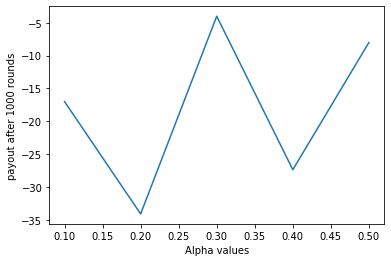

In [60]:
plt.plot(num_alpha_values,avg_payout_vs_alpha)
plt.xlabel('Alpha values')
plt.ylabel('payout after 1000 rounds')
plt.show()

In [61]:
num_epsilon_values = [0.1,0.2,0.3,0.4,0.5]
avg_payout_vs_eps=[]
for e in num_epsilon_values:
    step,rewards, qvalue = rummy.train(rummy_env, 
                                   gamma=0.5, 
                                   alpha=0.4, 
                                   epsilon=e, 
                                   maxiter=100, 
                                   maxstep=1000)
    avg_payout_vs_eps.append(sum(rewards)/len(rewards))

**********************************
		Game Starts : 0
***********************************
19
Kruti Plays
Player Name : Kruti 
 Stash Score: 15 
 Stash : 6H, 2S, 7D
Card in pile D4
Kruti takes action 0
Player Name : Kruti 
 Stash Score: 19 
 Stash : 6H, 2S, 7D, 4D
State  [6, 2, 7, 4]
Kruti drops card 6H
Player Name : Kruti 
 Stash Score: 13 
 Stash : 2S, 7D, 4D
18
Kruti Plays
Player Name : Kruti 
 Stash Score: 13 
 Stash : 2S, 7D, 4D
Card in pile H6
Kruti takes action 2
Player Name : Kruti 
 Stash Score: 19 
 Stash : 2S, 7D, 4D, 6D
State  [2, 7, 4, 6]
Kruti drops card 4D
Player Name : Kruti 
 Stash Score: 15 
 Stash : 2S, 7D, 6D
17
Kruti Plays
Player Name : Kruti 
 Stash Score: 15 
 Stash : 2S, 7D, 6D
Card in pile D4
Kruti takes action 0
Player Name : Kruti 
 Stash Score: 19 
 Stash : 2S, 7D, 6D, 4D
State  [2, 7, 6, 4]
Kruti drops card 2S
Player Name : Kruti 
 Stash Score: 17 
 Stash : 7D, 6D, 4D
16
Kruti Plays
Player Name : Kruti 
 Stash Score: 17 
 Stash : 7D, 6D, 4D
Card in pile S2
Kr

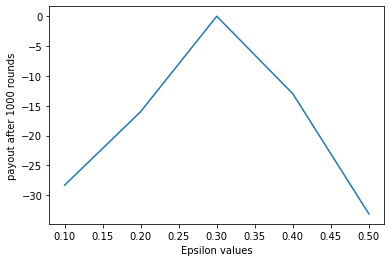

In [62]:
plt.plot(num_epsilon_values,avg_payout_vs_eps)
plt.xlabel('Epsilon values')
plt.ylabel('payout after 1000 rounds')
plt.show()

## Reading and analysis of learning results and plots

After choosing the proper parameters and evaluating the results we can find that the optimal value is the one in which the average payout is maximum. 
Note that the average payout values are in negative hence the low absolute value is actually higher negative value.

from the graphs, the optimal value of all the parameters are as follows <br>
epsilon = 0.3 <br>
alpha = 0.35 <br>
gamma = 0.4

# V. Conclusions

The main challenge in this assignment was figuring out the state dimensions for the Rummy problem. Understanding the abstract state dimensions was achievable but the technical dimensions where unclear and seemed to be rather dynamic depending on how we initialized the game. More clarification and direction on this front would alleviate much confusion and therefore would make the Rummy problem easier to follow.

On the other had the Rummy problem just simply doesn't seem suited for q-tables but more so function approximation. Due to my limited computing power I had to stop after few samples for the Rummy problem which even then barely saw any improvement.
Major challenge was to implement the Rummy Game. The technique to find the optimal value of gamma, epsilon and alpha took a while to be finalized.

# Extra Credit for Tournament Top16!

- In two classes, we will have qualification and tournament.
- To participate the tournament, you need to use this [client](http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/StudentClient.ipynb) codes.
- Locally you can run the [server](http://nbviewer.jupyter.org/url/webpages.uncc.edu/mlee173/teach/itcs6156/notebooks/assign/SERVER.ipynb) to verify your run. 

### Qualification Round 

- In qualification game, individual will play against a fixed policy agent on the server
  - You can access the server: TBA
  
  - Highly ranked (by the profit) will proceed to the tournament.
  - max. 32 players will be cut for main tournament (by 11 pm on Dec 1st).
  
### Tournament

- In tournament, 4 players will be play in each round.
  - In a table game, two best scoring players will proceed to next round
  - In final, the game will ends in 50 rounds and winner will be the one with lowest balance. 

## Grading

We will test your notebook with an additional grid.txt file. Please make sure to test in different maze input files. 

points | | description
--|--|:--
5 | Overview| states the objective and the appraoch 
35 | Methods | 
 |10| Review of the SARSA and Q-Learning
 | 5| Choice of TD learning and Reason
 | 5| Choice of Function Approximation and Reason
 |10| Implementation of the selected approach (RLAgent)
 | 5| explanation of the codes
45 | Results 
 |10| Reports the selected parameters 
 |15| Experimental outputs that show the choice of parameters. How do you choose them?
 |10| Output plots (5 for each)
 |10| reading and analysis of learning results and plots
10 | Participation to the tournament.
5 | Conclusions 
